# Data Scientist Associate Practical Exam Submission

## Arthur Polskih

### Background
You are working as a data scientist at a local University.
The university started offering online courses to reach a wider range of students.
The university wants you to help them understand enrollment trends.
They would like you to identify what contributes to higher enrollment. In particular, whether the course type (online or classroom) is a factor.

The dataset contains records for each course offered over the last 5 years.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import time

In [31]:
### Apply the desired style to all of the following plots

palette = sns.cubehelix_palette(start=0.5, rot=-.75, dark=0.3, light=0.8, reverse=True)
sns.set_palette(palette)
sns.set_style("darkgrid")
sns.set_context("notebook")

In [32]:
### Read the file, and get an overview of our data
data = pd.read_csv('university_enrollment_2306.csv')
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   course_id         1850 non-null   int64  
 1   course_type       1850 non-null   object 
 2   year              1850 non-null   int64  
 3   enrollment_count  1850 non-null   int64  
 4   pre_score         1850 non-null   object 
 5   post_score        1665 non-null   float64
 6   pre_requirement   1761 non-null   object 
 7   department        1850 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 115.8+ KB


(1850, 8)

In [33]:
print("Compare the description for each column:\n")

## course_id Data Validation
### Course ID should have no duplicate values
unique_id = True if data['course_id'].nunique() == data.shape[0] else False

### If no missing values, count should be 0
course_count_na = data['course_id'].isnull().sum()

print("----- course_id -----")
print(f"Column 'course_id' has only unique values: {unique_id}")
print(f"Sum of missing values: {course_count_na}")
print('\n')

## course_type Data Validation
### Column should have only "online" or "classroom" values
online_class = data['course_type'].unique()

### If no missing values, count should be 0
course_type_count_na = data['course_type'].isnull().sum()

print("----- course_type -----")
print(f"Values in this column: {online_class}")
print(f"Sum of missing values: {course_type_count_na}")
print('\n')

## year Data Validation
### Column should have only year values from 2011 to 2022
years = data['year'].unique()

### If no missing values, count should be 0
year_count_na = data['year'].isnull().sum()

print("----- year -----")
print(f"Values in this column: {years}")
print(f"Sum of missing values: {year_count_na}")
print('\n')

## enrollment_count Data Validation
### Column should have only discrete values
enrollment = data['enrollment_count'].describe()

### If no missing values, count should be 0
enrollment_count_na = data['enrollment_count'].isnull().sum()

print("----- enrollment_count -----")
print(f"Description of values in this column:\n{enrollment}")
print(f"Sum of missing values: {enrollment_count_na}")
print('\n')

## pre_score Data Validation
### Column should have only continuous values 
pre_score = data['pre_score'].describe()

### If no missing values, count should be 0
pre_score_count_na = data['pre_score'].isnull().sum()
pre_score_count_na += len(data[data['pre_score'] == '-']) # the missing values might appear as "-"

print("----- pre_score -----")
print(f"Description of values in this column:\n{pre_score}")
print(f"Sum of missing values before cleaning: {pre_score_count_na}")
print('\n')

## post_score Data Validation
### Column should have only continuous values 
post_score = data['post_score'].describe()

### If no missing values, count should be 0
post_score_count_na = data['post_score'].isnull().sum()
post_score_count_na += len(data[data['post_score'] == '-']) # the missing values might appear as "-"

print("----- post_score -----")
print(f"Description of values in this column:\n{post_score}")
print(f"Sum of missing values before cleaning: {post_score_count_na}")
print('\n')

## pre_requirement Data Validation
### Column should have only “None”, “Beginner”, “Intermediate” values 
pre_req = data['pre_requirement'].unique()

### If no missing values, count should be 0
pre_req_count_na = data['pre_requirement'].isnull().sum()
pre_req_count_na += len(data[data['pre_requirement'] == '-']) # the missing values might appear as "-"

print("----- pre_requirement -----")
print(f"Values in this column: {pre_req}")
print(f"Sum of missing values before cleaning: {pre_req_count_na}")
print('\n')

## department Data Validation
### Column should have only “Science”, “Technology”, “Engineering”, “Mathematics” values 
dep = data['department'].unique()

### If no missing values, count should be 0
dep_count_na = data['department'].isnull().sum()
dep_count_na += len(data[data['department'] == '-']) # the missing values might appear as "-"

print("----- department -----")
print(f"Values in this column: {dep}")
print(f"Sum of missing values before cleaning: {dep_count_na}")
print('\n')

Compare the description for each column:

----- course_id -----
Column 'course_id' has only unique values: True
Sum of missing values: 0


----- course_type -----
Values in this column: ['classroom' 'online']
Sum of missing values: 0


----- year -----
Values in this column: [2018 2020 2016 2013 2019 2014 2021 2022 2011 2015 2012 2017]
Sum of missing values: 0


----- enrollment_count -----
Description of values in this column:
count    1850.000000
mean      231.565405
std        36.987029
min       154.000000
25%       185.000000
50%       251.000000
75%       261.000000
max       267.000000
Name: enrollment_count, dtype: float64
Sum of missing values: 0


----- pre_score -----
Description of values in this column:
count     1850
unique    1594
top          -
freq       130
Name: pre_score, dtype: object
Sum of missing values before cleaning: 130


----- post_score -----
Description of values in this column:
count    1665.000000
mean       75.204805
std         8.511981
min        51.

In [34]:
# Data Cleaning
print("For each column that presented missing values, or incorrect description:\n")

### pre_score - replace missing values with 0
data['pre_score'] = data['pre_score'].fillna(0)
data.loc[data['pre_score'] == '-', 'pre_score'] = 0
pre_score_count_na = data['pre_score'].isnull().sum()
print("----- pre_score -----")
print(f"Sum of missing values after cleaning: {pre_score_count_na}\n")

### post_score - replace missing values with 0
data['post_score'] = data['post_score'].fillna(0)
data.loc[data['post_score'] == '-', 'post_score'] = 0
post_score_count_na = data['post_score'].isnull().sum()
print("----- post_score -----")
print(f"Sum of missing values after cleaning: {post_score_count_na}\n")

### pre_requirement - replace missing values with 'None'
data['pre_requirement'] = data['pre_requirement'].fillna('None')
data.loc[data['pre_requirement'] == '-', 'pre_requirement'] = 'None'
pre_req_count_na = data['pre_requirement'].isnull().sum()
print("----- pre_requirement -----")
print(f"Sum of missing values after cleaning: {pre_req_count_na}")
print(f"Unique values after cleaning: {data['pre_requirement'].unique()}\n")

### department - replace "Math" values with "Mathematics"
data['department'].replace('Math', 'Mathematics', inplace=True)
print("----- department -----")
print(f"Unique values after cleaning: {data['department'].unique()}")

For each column that presented missing values, or incorrect description:

----- pre_score -----
Sum of missing values after cleaning: 0

----- post_score -----
Sum of missing values after cleaning: 0

----- pre_requirement -----
Sum of missing values after cleaning: 0
Unique values after cleaning: ['Beginner' 'None' 'Intermediate']

----- department -----
Unique values after cleaning: ['Science' 'Mathematics' 'Technology' 'Engineering']


# Task 1 
## For every column in the data:
### a. State whether the values match the description given in the table above.
### b. State the number of missing values in the column.
### c. Describe what you did to make values match the description if they did not match.

The dataset provided contains **1850 rows and 9 columns** with missing values before data cleaning. We should validate all the values against the criteria for each column in the dataset:
- course_id: Matches the description as unique identifier with 0 missing values.
- course_type: All values are either 'online' or 'classroom' with 0 missing values.
- year: All values are between 2011 and 2022 inclusive with 0 missing values.
- enrollment_count: All values are discrete counts of enrollments with 0 missing values.
- pre_score: Contains continuous score data with **130 missing values**. Missing values were replaced with 0.
- post_score: Contains continuous score data with **185 missing values**. Missing values were replaced with 0.
- pre_requirement: All values are either 'None', 'Beginner' or 'Intermediate' **with 89 missing values**. Missing values were replaced with 'None'.
- department:  All values are either 'Science', 'Technology', 'Engineering', 'Mathematics', however, there were instances of 'Math' which is not in the given criteria. It was assumed that 'Math' refers to 'Mathematics' and these values were accordingly replaced.

# Task 2
## Describe the distribution of the enrollment counts. Your answer must include a visualization that shows the distribution.

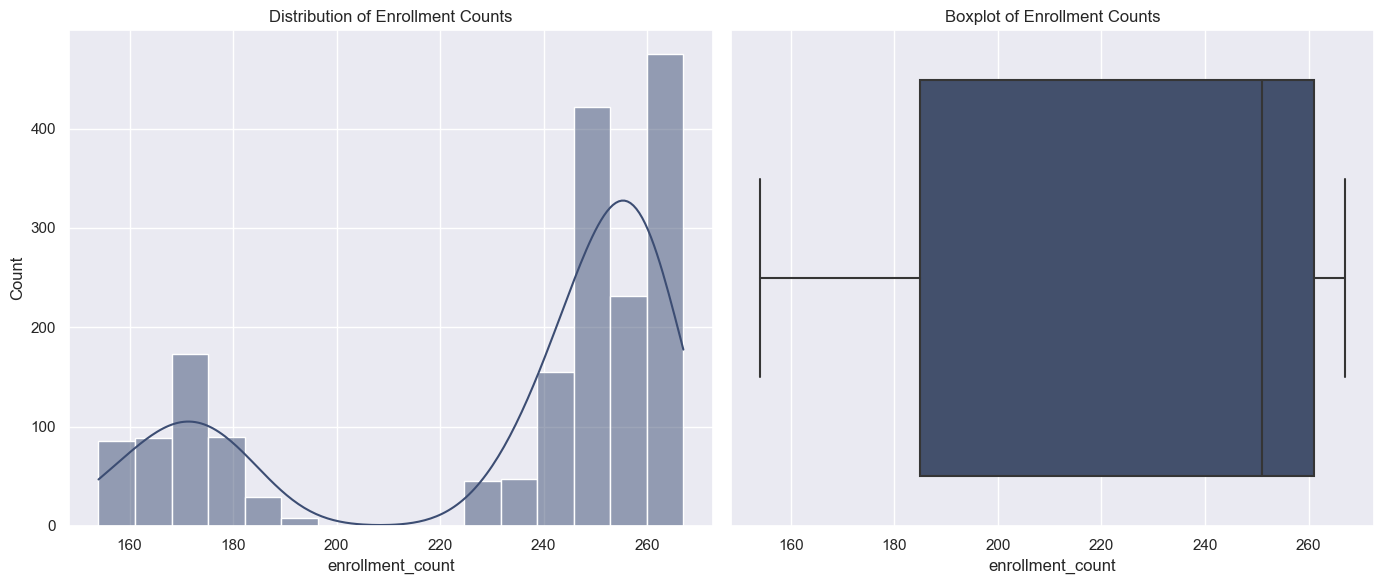

- Mean: 231.56540540540541
- Median: 251.0
- Mode: 261


In [35]:
### Creating subplots to have them side-by-side in our notebook
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

### Histogram with Kernel Density Estimate
sns.histplot(data['enrollment_count'], bins=16, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Enrollment Counts')

### Boxplot
sns.boxplot(x=data['enrollment_count'], ax=ax[1])
ax[1].set_title('Boxplot of Enrollment Counts')

plt.tight_layout()
plt.show()

### Calculate some important metrics
mean = data['enrollment_count'].mean()
median = data['enrollment_count'].median()
mode = data['enrollment_count'].mode()[0]

print(f"- Mean: {mean}")
print(f"- Median: {median}")
print(f"- Mode: {mode}")

The graphs above depict the distribution of student enrollments in the courses, as represented by the "enrollment_count" column. The histogram reveals two discernible clusters along the x-axis, the most prominent of which is around the region of 260 enrollments. This suggests that the majority of courses manage to attract around this number of students, as confirmed by the mode value of 261 and median value of 251. However, the histogram also reveals that some courses have far less enrollments at the region of 170, which could be due to ineffective marketing strategies, lack of interest in the subject matter, or even data entry errors. It would be beneficial to further investigate the factors contributing to this lack of enrollment in collaboration with the business analyst team.

The boxplot on the right provides a complementary view of the distribution, and it shows no outliers outside of minimun or maximum range.

# Task 3
## Create a visualization that shows how many courses were of each type.

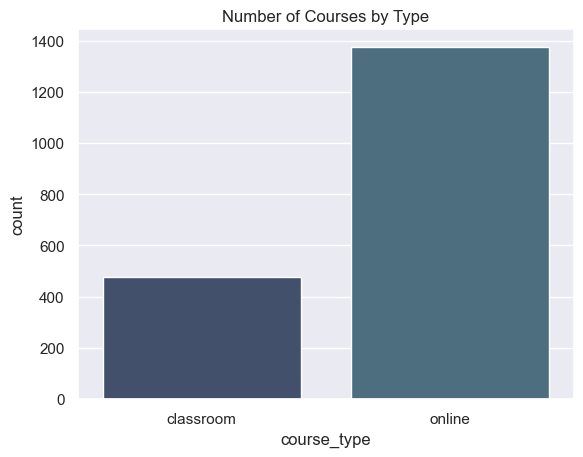

- Proportion of Online to Classroom Type of Courses: 74 %


In [36]:
### For this visualization, we can use a countplot
sns.countplot(data=data, x='course_type')
plt.title('Number of Courses by Type')
plt.show()

### Calculate and print the proportion
classroom = len(data[data['course_type'] == 'classroom'])
online = len(data) - classroom
print(f"- Proportion of Online to Classroom Type of Courses: {online/(online+classroom)*100:.0f} %")

### a. State which type of course has the most observations
According to the data, online courses have the most observations.

### b. Are the observations balanced across the types?

As clearly illustrated by the graph, the observations are not balanced across the two types of courses. Online courses make up approximately 74% of the total, leaving only 26% for classroom courses. This disproportion may potentially impact the results of our model by overrepresenting online courses. While we could employ data manipulation techniques to balance the proportions, we have opted to retain the current distribution for the purposes of this analysis. Future investigations could consider the impact of this imbalance on our results and potentially adopt corrective measures.

Overall, it is clear that online courses dominate our dataset. This observation may reflect the recent trend towards online education in the academic sector. Nevertheless, it is important to consider this imbalance when drawing conclusions from the data.

# Task 4
## Describe the relationship between course type and the enrollment count. Your answer must include a visualization to demonstrate the relationship.

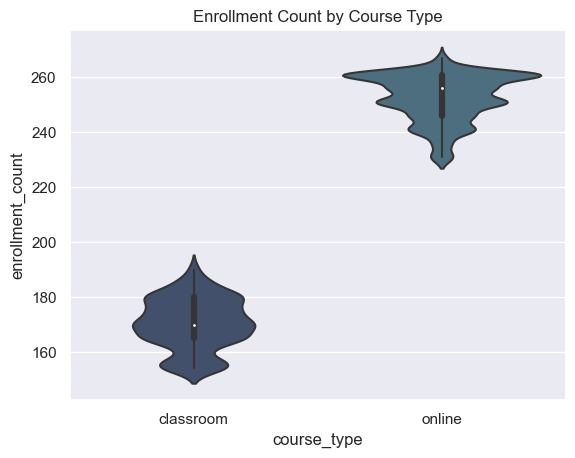

- Avg. enrollment count for Classroom Courses:  170
- Avg. enrollment count for Online Courses:  253


In [37]:
### A violin plot can help us visualize the distribution for each course type
sns.violinplot(x="course_type", y="enrollment_count", data=data)
plt.title('Enrollment Count by Course Type')
plt.show()

### Calculate and print the means
classroom = data[data['course_type'] == 'classroom']['enrollment_count'].mean()
online = data[data['course_type'] == 'online']['enrollment_count'].mean()

print(f"- Avg. enrollment count for Classroom Courses: {classroom: .0f}")
print(f"- Avg. enrollment count for Online Courses: {online: .0f}")

The graph above reveals a notable difference between the number of enrollments in online and classroom courses. Online courses not only outnumber classroom courses in terms of availability (as seen in the previous task), but they also appear to attract a larger number of students. The average enrollment for online courses is approximately 253 students, while classroom courses have an average closer to 170 students. Notably, the minimum and maximum values for each course type do not overlap, emphasizing the distinct difference in enrollment counts between the two types of courses.

One potential explanation for this trend is the inherent physical constraints of classroom-based courses, which can limit the number of students who can enroll. In contrast, online courses, unburdened by such limitations, can accommodate a larger number of students. As a result, they typically see a higher number of enrollments. This trend might also be influenced by changing societal norms and advancements in technology that have made online learning more accessible and popular.

Overall, the data suggests that course type plays a significant role in the number of enrollments a course can attract, with online courses generally seeing higher enrollments than their classroom counterparts.

# Task 5
## The university wants to predict how many students will enroll in a course. State the type of machine learning problem that this is (regression/ classification/ clustering).

The task of predicting the number of students who will enroll in a course is a **Regression** problem. Regression models are designed to predict a continuous outcome.

To achieve this, a regression model uses the features of the data (predictor variables such as course type, year, pre_score, post_score, pre_requirement, and department) to generate a prediction for the dependent variable (enrollment count). The model learns from the existing data, identifying patterns and relationships between the predictors and the outcome, and applies these patterns to make predictions for new, unseen data.

# Task 6
## Fit a baseline model to predict how many students will enroll using the data provided.

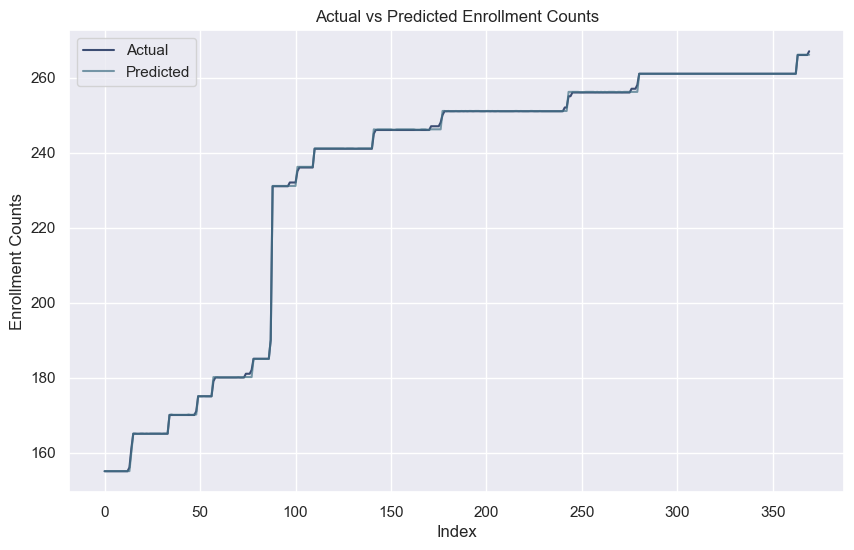

Linear Regression Performance in seconds: 0.008890628814697266
R-squared:  0.9999
RMSE: 0.31

----- 5-fold cross-validation -----

Cross-validated R-squared scores: [0.99990896 0.99992503 0.99993179 0.99992102 0.99991818]
Mean cross-validated R-squared score: 0.9999209967684702


In [38]:
## Linear Regression Model
### Define categorical columns to be encoded
categorical_cols = ['course_type', 'pre_requirement', 'department']

### Start the performance counter
lr_start_time = time.time()

### Create OneHotEncoder object
one_hot = OneHotEncoder()

### Preprocessing for categorical features
preprocessor = ColumnTransformer(transformers=[
    ('cat', one_hot, categorical_cols)
])

### Define target and predictor variables
y = data['enrollment_count']
X = data.drop(['enrollment_count', 'course_id'], axis=1)

### Traning and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing and model in a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('linearregression', LinearRegression())])

### Preprocessing of training data, fit model and get predictions 
model.fit(X_train, y_train)
preds = model.predict(X_test)

### Stop the performance counter
lr_end_time = time.time()

### Create variables for our metrics
lr_performance = lr_end_time - lr_start_time
lr_rmse = mean_squared_error(y_test, preds, squared=False)
lr_r2 = r2_score(y_test, preds)

### Perform 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

## Plot the comparison between actual and predicted values
compare_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
compare_df = compare_df.reset_index(drop=True)
compare_df.sort_values('Actual', inplace=True)
compare_df = compare_df.reset_index(drop=True)

plt.figure(figsize=(10,6))
plt.plot(compare_df['Actual'], label='Actual')
plt.plot(compare_df['Predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Enrollment Counts')
plt.xlabel('Index')
plt.ylabel('Enrollment Counts')
plt.legend()
plt.show()

print(f"Linear Regression Performance in seconds: {lr_performance}")
print(f"R-squared: {lr_r2: .4f}")
print(f"RMSE: {lr_rmse:.2f}\n")

print("----- 5-fold cross-validation -----\n")

print("Cross-validated R-squared scores:", scores)
print("Mean cross-validated R-squared score:", scores.mean())

For this dataset, we used a **Linear Regression** model as an initial baseline. This model aims to predict the target variable (enrollment_count) based on the other variables in our dataset.

The above plot illustrates the actual versus predicted enrollment counts for our Linear Regression model. Visually, our model appears to be very accurate, as corroborated by the high R-squared (0.999) and low RMSE metric scores.

However, there is a possibility of overfitting the model, which means that despite impressive results on the test set, the model may not perform as well on new, unseen data. To address this, we conducted a 5-fold cross-validation. The results of the cross-validation were equally impressive, providing greater confidence in the model's robustness. Nonetheless, we should continuously evaluate the model's accuracy with future data to ensure its reliability and performance.

# Task 7
## Fit a comparison model to predict how many students will enroll using the data provided.

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END max_depth=

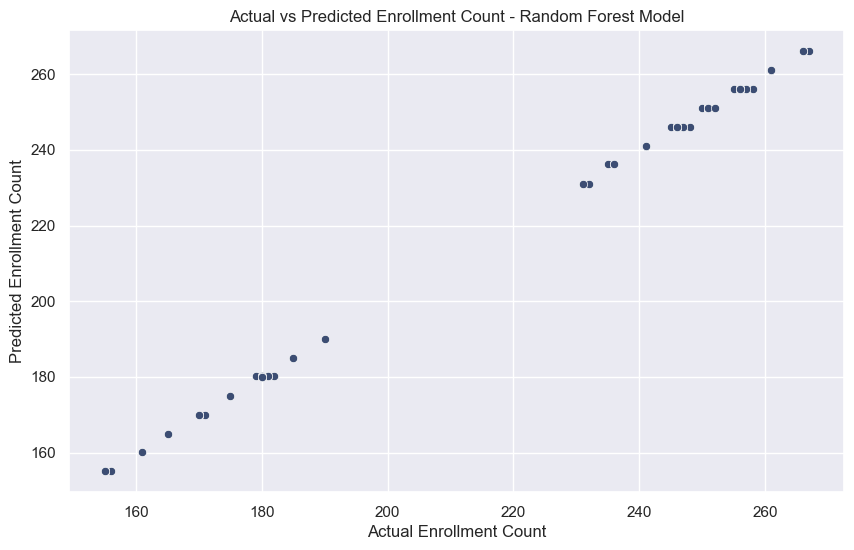

Linear Regression Performance in Seconds: 16.511620044708252
R-squared:  0.9999
RMSE:  0.32


In [39]:
## Random Forest Model
### Define categorical columns to be encoded
categorical_cols = ['course_type', 'pre_requirement', 'department']

### Start the performance counter
rf_start_time = time.time()

### Create the OneHotEncoder object
encoder = OneHotEncoder()

### Preprocessing for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_cols)])

### Fit and transform
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### Create the param grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

### Initialize RF object
rf = RandomForestRegressor(random_state=42)

### Apply the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

### Fit the grid search to the data and get best parameters to fit the model
grid_search.fit(X_train_transformed, y_train)
best_params = grid_search.best_params_

rf_best = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42
)

rf_best.fit(X_train_transformed, y_train)

### Predict on test
y_pred_rf = rf_best.predict(X_test_transformed)

### Evaluate the model
rf_end_time = time.time()
rf_performance = rf_end_time - rf_start_time
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

### Plot predicted vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel('Actual Enrollment Count')
plt.ylabel('Predicted Enrollment Count')
plt.title('Actual vs Predicted Enrollment Count - Random Forest Model')
plt.show()

print(f"Linear Regression Performance in Seconds: {rf_performance}")
print(f"R-squared: {rf_r2: .4f}")
print(f"RMSE: {rf_rmse: .2f}")


We utilized a **Random Forest** model as our comparison. Random Forest is an ensemble learning method, which combines many decision trees to generate more accurate predictions - and it's known to be a strong performer.

Our results using this model were impressive, similar to the previous linear regression model. The R-squared metric score was over 0.999, as well as a low RMSE, implying that the model's predictions are relatively close to the actual values.

The graph above illustrates the close correspondence between the predicted and actual enrollment counts. However, it's worth noting that the Random Forest model, while powerful, is also more computationally intensive than the simpler linear regression model. This can be especially evident when applying industry-standard techniques like GridSearchCV for hyperparameter tuning, which increases the computational load but often leads to improved model performance.

# Task 8
## Explain why you chose the two models used in parts 6 and 7

The choice of **Linear Regression** as a baseline model (Task 6) was due to its simplicity and efficiency. Linear Regression is a fundamental algorithm in machine learning that's well-suited to problems with a numerical target variable, like in this case for the number of students who will enroll in a course. Linear regression models are also fast to train and easy to interpret, which makes them an excellent choice for establishing a baseline model.

On the other hand, the **Random Forest** model (Task 7) was chosen as a more complex, comparison model due to its robustness and high performance. This method tends to perform well even on datasets with a mix of numerical and categorical features and can handle non-linear relationships between features and the target variable. While this model is more computationally intensive than a linear regression model, it often offers superior predictive performance.

# Task 9
## Compare the performance of the two models used in parts 6 and 7, using any method suitable.

Linear Regression performs 0.999% faster when compared to our Random Forest Model


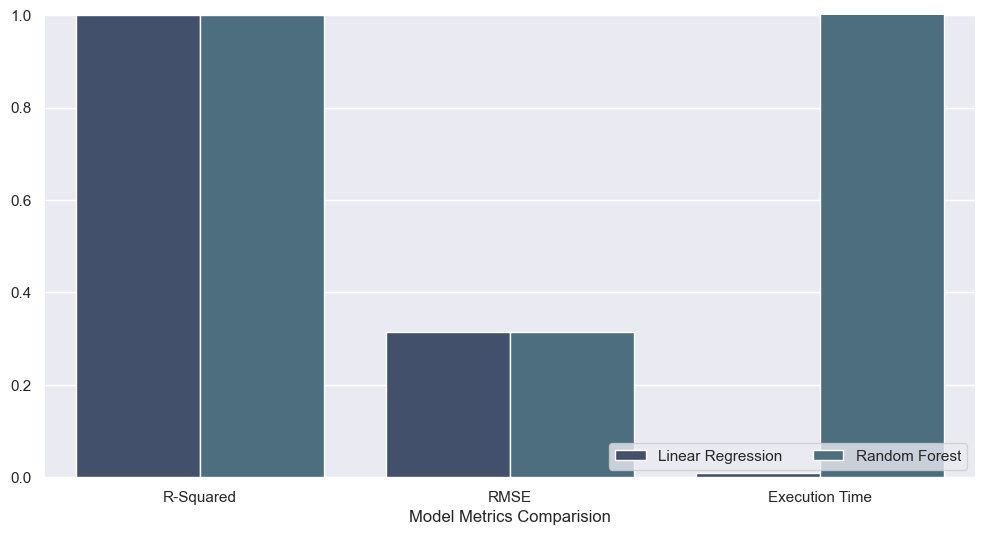

In [40]:
### Compare metrics and execution time
comparison_dict = {"Model": ["Linear Regression", "Random Forest"],
                   "R-Squared": [lr_r2, rf_r2],
                   "RMSE": [lr_rmse, rf_rmse],
                   "Execution Time": [lr_performance, rf_performance]}

comparison_df = pd.DataFrame(comparison_dict)

### Reshape DataFrame for seaborn
comparison_df_melt = comparison_df.melt('Model', var_name='Metrics', value_name='Values')

### Plot total metrics
f, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x="Metrics", y="Values", hue="Model", data=comparison_df_melt)

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 1), ylabel="", xlabel="Model Metrics Comparision")
sns.despine(left=True, bottom=True)

print(f"Linear Regression performs {rf_performance/(lr_performance + rf_performance):.3f}% faster when compared to our Random Forest Model")

We chose to visually compare the metrics and execution time in a 0-1 y-limited graph, and comparing the percentage difference between the execution times.

# Task 10
## Explain which model performs better and why.

In comparing the two models through our 0-1 y-limited graph, it becomes evident that both models perform remarkably well in terms of R-squared and RMSE metrics. However, there is a critical distinction when we consider execution time, with Linear Regression outpacing the more computationally intensive Random Forest model.

Despite their comparable performance in prediction accuracy, the simplicity and speed of the Linear Regression model are undeniable advantages in our dataset, especially in a production environment where efficiency is very important. This underscores a common trade-off in data science: balancing model complexity, prediction accuracy, and computational efficiency. For our needs, it seems the more straightforward **Linear Regression model** could potentially be a more suitable choice to predict the number of enrollments for the University.